In [27]:
#day11
import pandas as pd
data = [[1, 100], [2, 200], [3, 300]]
employee = pd.DataFrame(data, columns=['id', 'salary']).astype({'id':'int64', 'salary':'int64'})

# Reasoning
# Sort the employee by salary largest to smallest
# Find the first value that is not equal to the first salary | remove duplicates and get the nth salary (keep first indtance)
# returns a generate frame
def second_highest_salary(employee: pd.DataFrame) -> pd.DataFrame:
    # Creates a non duplicate dataframe of the salary column
    unique_salaries = employee["salary"].drop_duplicates()
    if len(unique_salaries) < 2:
        return pd.DataFrame({'SecondHighestSalary': [None]})
        
    unique_salaries = unique_salaries.sort_values(ascending=False)
    secondHighest = unique_salaries.iloc[1]
    return pd.DataFrame({'SecondHighestSalary': [secondHighest]})
    
# Panda series is a one dimentional labeled array - i.e., single column of dataframe
# Data frame is two dimensional structure labeled

second_highest_salary(employee)

,SecondHighestSalary
0,200


In [ ]:
"""
SQL version
SELECT (
    SELECT DISTINCT salary
    FROM Employee ORDER BY salary DESC 
    LIMIT 1 OFFSET 1   #Limits to 1 row and skips the first row
) as SecondHighestSalary # Wraps the out and renames the result as second highest salary
"""

In [44]:
#day12 Not accepted

import pandas as pd
data = [[1, 'Joe', 70000, 1], [2, 'Jim', 90000, 1], [3, 'Henry', 80000, 2], [4, 'Sam', 60000, 2], [5, 'Max', 90000, 1]]
employee = pd.DataFrame(data, columns=['id', 'name', 'salary', 'departmentId']).astype({'id':'Int64', 'name':'object', 'salary':'Int64', 'departmentId':'Int64'})
data = [[1, 'IT'], [2, 'Sales']]
department = pd.DataFrame(data, columns=['id', 'name']).astype({'id':'Int64', 'name':'object'})

# Highest salary each department
# Group employees by department
# Order by distinct / get the maximum row
# Recreate the dataframe using the id for that department

# See this blog = https://saturncloud.io/blog/how-to-select-row-with-max-value-in-column-from-pandas-groupby-groups/
# Transform can be used to broadcast back the group function onto the dataframe
def department_highest_salary(employee: pd.DataFrame, department: pd.DataFrame) -> pd.DataFrame:
    # Use groupby to group the data by a specific column
    groups = employee.groupby('departmentId')
    # Get the idx of the max values of specific column. idx is a pandas series that contains row index of maximum value of each group
    idx = groups['salary'].idxmax()
    # loc selects rows with these indexes
    max_salaries = employee.loc[idx]

    # Do a lookup and replace the departmentId - use pandas repalce
    # using replace we need to generate a dictionary to map id to name
    # We will use a simple zip
    depMap = dict(zip(department['id'], department['name']))

    # Altenatively since we know that id is the primary key we can use set index to to dict on the dataframe
    depMap = department.set_index('id')['name'].to_dict()

    # Unfortunately the above doens't work in replcae since the data type is diffrent we will use map
    # ! will fail due to column type: max_salaries.replace({'departmentId': depMap})
    max_salaries['Department'] = max_salaries['departmentId'].map(depMap)
    
    # rename / reorder the data frame
    return pd.DataFrame({'Department': max_salaries['Department'], 'Employee': max_salaries['name'], 
                        'Salary': max_salaries['salary']})

department_highest_salary(employee, department)

,Department,Employee,Salary
1,IT,Jim,90000
2,Sales,Henry,80000


In [53]:
#day12 Using probper boolean filtering for duplicate max entries
# Accepted
import pandas as pd
data = [[1, 'Joe', 70000, 1], [2, 'Jim', 90000, 1], [3, 'Henry', 80000, 2], [4, 'Sam', 60000, 2], [5, 'Max', 90000, 1]]
employee = pd.DataFrame(data, columns=['id', 'name', 'salary', 'departmentId']).astype({'id':'Int64', 'name':'object', 'salary':'Int64', 'departmentId':'Int64'})
data = [[1, 'IT'], [2, 'Sales']]
department = pd.DataFrame(data, columns=['id', 'name']).astype({'id':'Int64', 'name':'object'})

"""
SQL
SELECT DEPT.name AS Department, EMP.name AS Employee, EMP.salary AS 

Salary FROM Department DEPT, Employee EMP WHERE

EMP.departmentId = DEPT.id AND (EMP.departmentId, salary) IN 

(SELECT departmentId, MAX (salary) FROM Employee GROUP BY 

departmentId)
"""
def department_highest_salary(employee: pd.DataFrame, department: pd.DataFrame) -> pd.DataFrame:

    # get all the max salaries
    max_salaries = employee.groupby('departmentId')['salary'].transform('max')

    # generate a boolean series where the salary is equal to the max
    df = employee[max_salaries == employee['salary']]

    # Generate the map to map id to department name
    depMap = department.set_index('id')['name'].to_dict()

    #Ensure the original dataframe is being modified - otherwise we get A value is trying to be set on a copy of a slice from a DataFrame.
    df.loc[:,'Department'] = df['departmentId'].map(depMap)
    
    # rename / reorder the data frame
    return pd.DataFrame({'Department': df['Department'], 'Employee': df['name'], 
                        'Salary': df['salary']})

department_highest_salary(employee, department)

C:\Users\MICHAEL\AppData\Local\Temp\ipykernel_25988\2429914438.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Department'] = df['departmentId'].map(depMap)


,Department,Employee,Salary
1,IT,Jim,90000
2,Sales,Henry,80000
4,IT,Max,90000


In [114]:
#day13
import pandas as pd
data = [[1, 3.5], [2, 3.65], [3, 4.0], [4, 3.85], [5, 4.0], [6, 3.65]]
scores = pd.DataFrame(data, columns=['id', 'score']).astype({'id':'Int64', 'score':'Float64'})

"""
SQL
SELECT S.Score, COUNT(S2.Score) AS Rank  # Selecting S.Score (column) and the Rank
FROM Scores S, (SELECT DISTICT score FROM scores) S2 # Define S as Score and S2 - Furthemore we get COUNT
WHERE S.Score <= S2.Score # This filters the rows for the condition on each row - Also this joins the tables
GROUP BY S.Id 
ORDER BY S.Score DESC; # Finish the order result
"""
def order_scores(scores: pd.DataFrame) -> pd.DataFrame:
    # This is a series containing the unique scores in ascending order
    unique_scores = scores['score'].drop_duplicates().sort_values(ascending=False)
    # This generates a dataframe with new indexes 0 to n the old index is stored in the index column which we will drop - Reset index convert to a dataframe
    df = unique_scores.reset_index().filter(['score'])
    # Create a tank column
    df["rank"] = range(1, len(df) + 1)
    
    # Convert score column to a dictionart key then create dict score -> rank
    df = df.set_index('score')
    rank_map = df['rank'].to_dict()
    
    scores['rank'] = scores['score'].map(rank_map)
    
    # Reset index without creating a new column
    return scores.sort_values('score', ascending=False).drop(columns=['id']).reset_index(drop=True)
# Alternative solution for the Rank Scores in pandas
# Use the dense method
"""
def order_scores(scores: pd.DataFrame) -> pd.DataFrame:
    # Use the rank method to assign ranks to the scores in descending order with no gaps
    scores['rank'] = scores['score'].rank(method='dense', ascending=False)
    
    # Drop id column & Sort the DataFrame by score in descending order
    result_df = scores.drop('id',axis=1).sort_values(by='score', ascending=False)
    
    return result_df
"""
order_scores(scores)

,score,rank
0,4.0,1
1,4.0,1
2,3.85,2
3,3.65,3
4,3.65,3
5,3.5,4


SQL
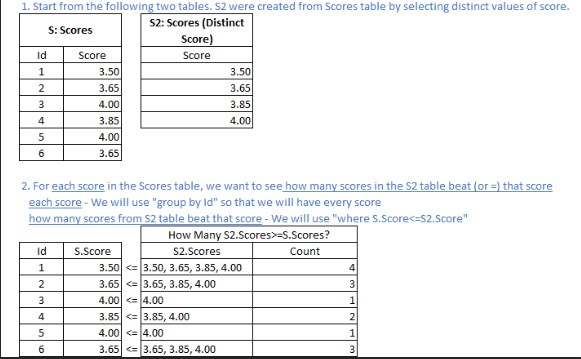

In [118]:
#day14

# Using inplace operation
"""
SQL
DELETE p1 # if block
FROM Person p1, Person p2 # This is like a for i and for j loop - Actually joins the table on itself by the email p1.Id | p1.Email | p2.Id | p2.Email pairs each p1 with each row p2
WHERE p1.Email = p2.Email AND p1.id > p2.id # if condition
"""
import pandas as pd
data = [[1, 'john@example.com'], [2, 'bob@example.com'], [3, 'john@example.com']]
person = pd.DataFrame(data, columns=['id', 'email']).astype({'id':'int64', 'email':'object'})
def delete_duplicate_emails(person: pd.DataFrame) -> None:
    person.sort_values('id', inplace=True)
    person.drop_duplicates('email', inplace=True)

delete_duplicate_emails(person)
person.head()
    

,id,email
0,1,john@example.com
1,2,bob@example.com


In [ ]:
import pandas as pd
data = [[0, 95, 100, 105], [1, 70, None, 80]]
products = pd.DataFrame(data, columns=['product_id', 'store1', 'store2', 'store3']).astype({'product_id':'Int64', 'store1':'Int64', 'store2':'Int64', 'store3':'Int64'}) 
def rearrange_products_table(products: pd.DataFrame) -> pd.DataFrame:
    # melt consolidates a wide format into a long one - it reduces the columns and joints them namely store
    # this format is more normalized and esaier to analyze - wide formats are like contains where we have a single 
    # identifier and multiple categories holding the same type of value. This is also a normalization process. reducing reducncy for each column
    # now its easier to filter. 
    return pd.melt(
        products, id_vars='product_id', var_name='store', value_name='price'
    ).dropna()
# Transform! For each time it occurs in the store column then add that as a row and take the value as price
# Create a new table generate n rows for each product eqaul to non empty entries in store
# Create new table product_transform
    # For each product for each non n/a entry in store1, store2, store3 as store 
        # new row = product | store | cost = Products[product][store]
        # add new row to the table product_transform

# Accepted
"""
Purpose:
The function rearrange_products_table transforms a wide DataFrame (multiple store columns) into a long DataFrame with one row per product per store.
This format is often easier to work with for data analysis or visualization tasks.
"""